# 02 - Análise exploratória (cs.LG.csv)

## Integrantes da equipe

>   Eduardo Marcelino Junior, 2028409, @eduardo.marcelino, BSI, UTFPR
>
>   Otávio Baziewicz Filho, 1942808, @worgho2, BSI, UTFPR
>
>   Rodrigo William Chavoni, 1996169, @rodrigochavoni, BSI, UTFPR

<!-- -   Para o projeto iremos utilizar 5 subcampos da ciência da computação, que são:
    -   df_AI: Artificial Intelligence
    -   df_DC: Distributed, Parallel, and Cluster Computing
    -   df_IR: Information Retrieval
    -   df_LG: Machine Learning
    -   df_NE: Neural and Evolutionary Computing
-   As bases possuem as mesmas colunas, que são:
    -   ID
    -   Updated
    -   Published
    -   Title
    -   Summary - Resumo do Artigo
    -   Authors
    -   Categories
-   O principal objetivo é analisar a coluna 'Summary', que contém os resumos dos artigos.
-   Primeiramente uma análise individual para cada categoria. Podendo serem feitas:
    -   Nuvem de palavras;
    -   Análise de Tópicos;
    -   (pensar em mais...)
-   Após a primeira análise individual, tentar relacionar as subcategorias.  -->

## Bibliotecas

In [1]:
# Geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
import pyLDAvis.lda_model

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

## Carregamento

In [3]:
# Carregamento dos dados 
def load_data(filename):
    return pd.read_csv(f"../output/data/{filename}")

data = load_data("cs.LG.csv").sample(1000)

## Apresentação

In [4]:
# Apresentação dos dados
def show_data_info(data: pd.DataFrame):
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.values}")
    print("Sample:")
    display(data.head())

show_data_info(data)

Shape: (1000, 7)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories
1571,http://arxiv.org/abs/1609.03323v3,2017-01-13T12:30:39Z,2016-09-12T09:33:57Z,Sensor-based Gait Parameter Extraction with De...,"Measurement of stride-related, biomechanical...","Julius Hannink, Thomas Kautz, Cristian F. Pasl...",cs.LG
9567,http://arxiv.org/abs/2209.06429v1,2022-09-14T05:45:46Z,2022-09-14T05:45:46Z,A Hybrid Deep Learning Model-based Remaining U...,Reed relay serves as the fundamental compone...,"Chinthaka Gamanayake, Yan Qin, Chau Yuen, Lahi...",cs.LG
2564,http://arxiv.org/abs/1902.08869v1,2019-02-24T01:12:21Z,2019-02-24T01:12:21Z,Statistical Method to Model the Quality Incons...,Resistance Spot Welding (RSW) is an importan...,"Mohammad Aminisharifabad, Qingyu Yang",cs.LG
2012,http://arxiv.org/abs/1706.02295v1,2017-06-07T10:19:30Z,2017-06-07T10:19:30Z,Generative-Discriminative Variational Model fo...,The paradigm shift from shallow classifiers ...,"Chih-Kuan Yeh, Yao-Hung Hubert Tsai, Yu-Chiang...",cs.LG
6197,http://arxiv.org/abs/2110.10423v4,2023-03-13T06:18:52Z,2021-10-20T08:18:16Z,ProxyBO: Accelerating Neural Architecture Sear...,Designing neural architectures requires imme...,"Yu Shen, Yang Li, Jian Zheng, Wentao Zhang, Pe...",cs.LG


## Normalização dos dados

In [5]:
# Normalização dos dados (remoção de stopwords, pontuação, etc)
def normalize_text(text: str):
    stopword_list = nltk.corpus.stopwords.words('english')
    return  " ".join([word for word in word_tokenize(text.lower()) if word not in stopword_list and word.isalpha()])


# Geração de coluna normalizada com base em outra coluna
def generate_normalized_column(data: pd.DataFrame, from_column: str):
    new_column_name = f"{from_column}_Normalized"
    print(f"New column name: {new_column_name}")
    data[new_column_name] = data.apply(lambda linha: normalize_text(str(linha[from_column])), axis = 1)
    return new_column_name


normalized_summary_column_name = generate_normalized_column(data=data, from_column="Summary")
show_data_info(data)

New column name: Summary_Normalized
Shape: (1000, 8)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized
1571,http://arxiv.org/abs/1609.03323v3,2017-01-13T12:30:39Z,2016-09-12T09:33:57Z,Sensor-based Gait Parameter Extraction with De...,"Measurement of stride-related, biomechanical...","Julius Hannink, Thomas Kautz, Cristian F. Pasl...",cs.LG,measurement biomechanical parameters common ra...
9567,http://arxiv.org/abs/2209.06429v1,2022-09-14T05:45:46Z,2022-09-14T05:45:46Z,A Hybrid Deep Learning Model-based Remaining U...,Reed relay serves as the fundamental compone...,"Chinthaka Gamanayake, Yan Qin, Chau Yuen, Lahi...",cs.LG,reed relay serves fundamental component functi...
2564,http://arxiv.org/abs/1902.08869v1,2019-02-24T01:12:21Z,2019-02-24T01:12:21Z,Statistical Method to Model the Quality Incons...,Resistance Spot Welding (RSW) is an importan...,"Mohammad Aminisharifabad, Qingyu Yang",cs.LG,resistance spot welding rsw important manufact...
2012,http://arxiv.org/abs/1706.02295v1,2017-06-07T10:19:30Z,2017-06-07T10:19:30Z,Generative-Discriminative Variational Model fo...,The paradigm shift from shallow classifiers ...,"Chih-Kuan Yeh, Yao-Hung Hubert Tsai, Yu-Chiang...",cs.LG,paradigm shift shallow classifiers features tr...
6197,http://arxiv.org/abs/2110.10423v4,2023-03-13T06:18:52Z,2021-10-20T08:18:16Z,ProxyBO: Accelerating Neural Architecture Sear...,Designing neural architectures requires imme...,"Yu Shen, Yang Li, Jian Zheng, Wentao Zhang, Pe...",cs.LG,designing neural architectures requires immens...


## Histograma e Nuvem de Palavras

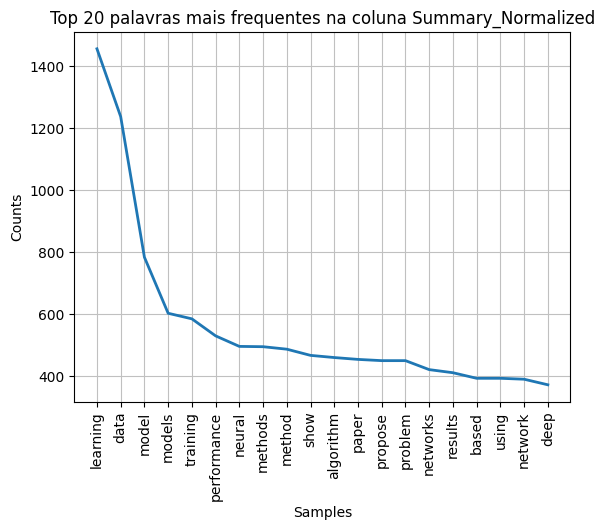

C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


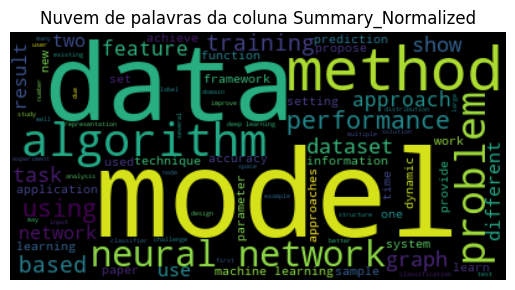

In [6]:
# Geração do histograma de frequência de palavras
def plot_word_frequency_histogram_and_wordcloud(data: pd.DataFrame, column: str, top: int):
    column_data = " ".join(data[column])

    # Histograma
    fdist = FreqDist(column_data.split(" "))
    fdist.plot(top, title=f"Top {top} palavras mais frequentes na coluna {column}")

    # Wordcloud
    wordcloud = WordCloud().generate(column_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuvem de palavras da coluna {column}")
    plt.axis("off")
    plt.show()

plot_word_frequency_histogram_and_wordcloud(data=data, column=normalized_summary_column_name, top=20)

## Polaridade e Subjetividade

In [7]:
# Adição de coluna de polaridade e subjetividade com base em outra coluna
def generate_polarity_and_subjectivity_columns(data: pd.DataFrame, from_column: str):
    new_polarity_column_name = f"{from_column}_Polarity"
    data[new_polarity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.polarity)

    new_subjectivity_column_name = f"{from_column}_Subjectivity"
    data[new_subjectivity_column_name] = data[from_column].apply(lambda text: TextBlob(text).sentiment.subjectivity)

    return new_polarity_column_name, new_subjectivity_column_name

normalized_summary_polarity_column_name, normalized_summary_subjectivity_column_name = generate_polarity_and_subjectivity_columns(data=data, from_column=normalized_summary_column_name)
show_data_info(data)

Shape: (1000, 10)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories'
 'Summary_Normalized' 'Summary_Normalized_Polarity'
 'Summary_Normalized_Subjectivity']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories,Summary_Normalized,Summary_Normalized_Polarity,Summary_Normalized_Subjectivity
1571,http://arxiv.org/abs/1609.03323v3,2017-01-13T12:30:39Z,2016-09-12T09:33:57Z,Sensor-based Gait Parameter Extraction with De...,"Measurement of stride-related, biomechanical...","Julius Hannink, Thomas Kautz, Cristian F. Pasl...",cs.LG,measurement biomechanical parameters common ra...,-0.010193,0.317783
9567,http://arxiv.org/abs/2209.06429v1,2022-09-14T05:45:46Z,2022-09-14T05:45:46Z,A Hybrid Deep Learning Model-based Remaining U...,Reed relay serves as the fundamental compone...,"Chinthaka Gamanayake, Yan Qin, Chau Yuen, Lahi...",cs.LG,reed relay serves fundamental component functi...,0.185913,0.383532
2564,http://arxiv.org/abs/1902.08869v1,2019-02-24T01:12:21Z,2019-02-24T01:12:21Z,Statistical Method to Model the Quality Incons...,Resistance Spot Welding (RSW) is an importan...,"Mohammad Aminisharifabad, Qingyu Yang",cs.LG,resistance spot welding rsw important manufact...,0.108333,0.448810
2012,http://arxiv.org/abs/1706.02295v1,2017-06-07T10:19:30Z,2017-06-07T10:19:30Z,Generative-Discriminative Variational Model fo...,The paradigm shift from shallow classifiers ...,"Chih-Kuan Yeh, Yao-Hung Hubert Tsai, Yu-Chiang...",cs.LG,paradigm shift shallow classifiers features tr...,0.030208,0.365625
6197,http://arxiv.org/abs/2110.10423v4,2023-03-13T06:18:52Z,2021-10-20T08:18:16Z,ProxyBO: Accelerating Neural Architecture Sear...,Designing neural architectures requires imme...,"Yu Shen, Yang Li, Jian Zheng, Wentao Zhang, Pe...",cs.LG,designing neural architectures requires immens...,0.079167,0.387500


## Lemmatization

In [8]:
# Aplicação de lematização em coluna, retornando uma lista de palavras em sua forma raiz
def apply_lemmatization_to_column(data: pd.DataFrame, column: str, allowed_postags: list[str] = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load("en_core_web_sm")

    column_words = data[column].map(lambda text: TextBlob(text).words)

    lemma_column_words = []
    for words in column_words:
        doc = nlp(" ".join(words))
        lemma_column_words.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))

    return lemma_column_words

summary_lemma = apply_lemmatization_to_column(data=data, column=normalized_summary_column_name)

## Vetorização

In [9]:
summary_vectorizer = CountVectorizer(
    analyzer='word',       
    min_df=10,                        # minimum required occurences of a word 
    stop_words='english',             # remove stop words
    lowercase=True,                   # convert all words to lowercase
    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
    # max_features=50000,             # max number of unique words
)

vectorized_summary_lemma = summary_vectorizer.fit_transform(summary_lemma)

## Sparsity

In [10]:
def get_vectorized_lemma_sparcity(vectorized_lemma: np.ndarray):
    dense_vectorized_lemma = vectorized_lemma.todense()
    return ((dense_vectorized_lemma > 0).sum()/dense_vectorized_lemma.size)*100

print(f"Sparcity: {get_vectorized_lemma_sparcity(vectorized_lemma=vectorized_summary_lemma)}%")

Sparcity: 4.3662104362703165%


## LDA Grid Search

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -100247.5083739738
Model Perplexity:  620.4780312938418


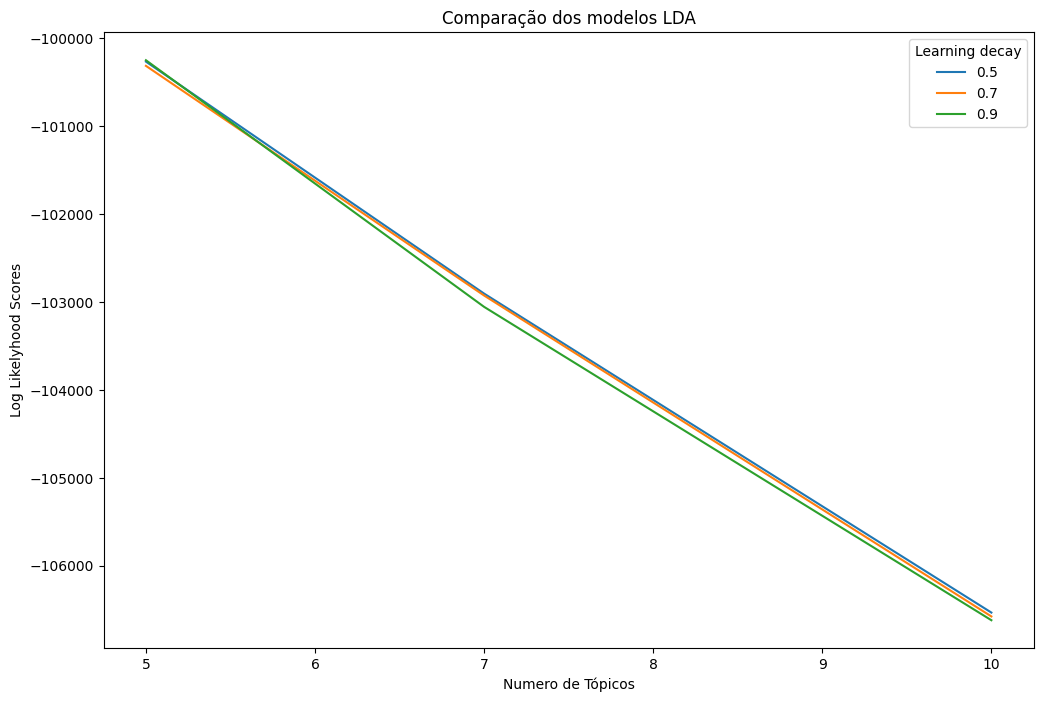

In [19]:
# Geração de modelo LDA com base em parâmetros otimizados pelo GridSearch
lda = LatentDirichletAllocation()
search_params = {
    'n_components': [5, 7, 10],
    'learning_decay': [.5, .7, .9]
}
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vectorized_summary_lemma)

# Parâmetros do melhor modelo
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(vectorized_summary_lemma))


# Visualização dos parâmetros otimizados pelo GridSearch
plt.figure(figsize=(12, 8))
for i in range(len(search_params['learning_decay'])):
    plt.plot(
        search_params['n_components'],
        [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==search_params['learning_decay'][i]],
        label=str(search_params['learning_decay'][i])
    )
plt.title("Comparação dos modelos LDA")
plt.xlabel("Numero de Tópicos")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


## Análise de Tópicos

In [20]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(vectorized_summary_lemma)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data[normalized_summary_column_name]))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,0.00,0.07,0.62,0.07,0.23
Doc1,0.00,0.11,0.46,0.00,0.43
Doc2,0.00,0.17,0.00,0.00,0.81
Doc3,0.00,0.00,0.99,0.00,0.00
Doc4,0.71,0.00,0.00,0.28,0.00
...,...,...,...,...,...
Doc995,0.00,0.22,0.00,0.39,0.38
Doc996,0.00,0.00,0.45,0.54,0.00
Doc997,0.00,0.98,0.00,0.00,0.00
Doc998,0.00,0.00,0.99,0.00,0.00


In [21]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.000000,0.070000,0.620000,0.070000,0.230000,2
Doc1,0.000000,0.110000,0.460000,0.000000,0.430000,2
Doc2,0.000000,0.170000,0.000000,0.000000,0.810000,4
Doc3,0.000000,0.000000,0.990000,0.000000,0.000000,2
Doc4,0.710000,0.000000,0.000000,0.280000,0.000000,0
Doc5,0.010000,0.010000,0.010000,0.980000,0.010000,3
Doc6,0.510000,0.140000,0.000000,0.000000,0.340000,0
Doc7,0.000000,0.870000,0.120000,0.000000,0.000000,1
Doc8,0.000000,0.000000,0.200000,0.790000,0.000000,3
Doc9,0.000000,0.000000,0.000000,0.000000,0.990000,4


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,348
1,4,227
2,3,172
3,1,157
4,0,96


In [23]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = summary_vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,accelerate,access,accord,account,accuracy,accurate,accurately,achieve,...,way,weak,weight,wide,widely,word,work,world,year,yield
Topic0,7.662838,0.261917,4.105567,12.646054,4.774196,0.203151,13.326411,0.201004,1.598321,45.163746,...,12.768003,0.202325,10.600331,4.974154,11.127467,0.202587,60.322935,6.408501,14.710437,0.269763
Topic1,0.205153,7.055379,0.204046,2.183431,5.568725,15.705156,18.985494,6.677639,6.759233,20.830748,...,0.477197,7.726368,31.215818,0.598423,12.248502,6.310014,49.254038,0.203758,4.751354,15.317914
Topic2,34.124319,28.766700,0.203352,10.143662,9.071086,2.164621,177.166969,22.613097,4.687441,85.232900,...,32.610833,2.870222,54.377762,15.541361,4.221488,5.609806,112.703256,7.878843,15.558930,10.747653
Topic3,3.233423,16.170686,11.670383,3.851437,1.737316,5.937921,11.195608,4.309822,3.114325,73.746019,...,22.645648,0.206345,26.523183,18.490182,0.222137,0.648480,49.646342,8.539645,0.275654,11.454814
Topic4,37.774268,15.745318,4.816652,1.175416,0.848676,7.989151,55.325519,19.198437,13.840680,32.026586,...,29.498319,3.994740,0.282907,8.395879,14.180406,1.229114,86.073429,13.969253,13.703626,16.209856


In [24]:
# Show top n keywords for each topic
def show_topics(vectorizer=summary_vectorizer, lda_model=lda_output, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=summary_vectorizer, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,graph,network,datum,learn,neural,model,propose,information,performance,federate,training,method,task,framework,learning
Topic 1,datum,use,cluster,model,method,loss,result,set,function,matrix,base,learn,sample,error,propose
Topic 2,model,datum,network,learn,feature,method,use,training,dataset,neural,propose,deep,task,learning,performance
Topic 3,learn,problem,policy,function,algorithm,optimization,method,gradient,result,learning,propose,reward,performance,set,reinforcement
Topic 4,model,learn,approach,time,use,propose,problem,method,datum,graph,base,machine,paper,dynamic,process


### LDAVis

In [25]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, vectorized_summary_lemma, summary_vectorizer, mds='tsne')


pyLDAvis.display(panel)

In [26]:
pyLDAvis.save_html(panel, 'C:\\Users\\rodri\\Documents\\recuperacao-de-informacao\\02 - Analise exploratoria\\arxiv\\ldavis_html\\lda_lg.html')